In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [82]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = np.NaN
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [30]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [31]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [53]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    #(df['connections'] + df['ini']) * df['N_VP'] / df['N_conns_sum'] * 1024**2
    return df

In [83]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45, mem_other=True):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    if mem_other:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    else:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per VP'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per VP')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    if mem_other:
        df_p['other'] = df_mem['other']
    return df_p

In [84]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, logy=False):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))
    #fig, axes = plt.subplots(nrows=2, ncols=2)

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                            logy=logy, legend=False)
    axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)', fontsize=fontsize_axis, rot=rot, legend=False)
    #axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)', fontsize=fontsize_axis, rot=rot, legend=False)
    #df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis, rot=rot, legend=False)
    #df_p['Memory per Rank'].plot(kind='bar', ax = axes[1][1], title='Memory per Rank', fontsize=fontsize_axis, rot=rot, legend=False)
        
    plt.subplots_adjust(wspace=0.5)#, hspace=0.7)

    # y-axis labels
    if 'Conn. Creation Time \n per Conn. (min)' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        axes[0].set_ylabel('Time [s]')
        #axes[0][0].set_ylabel('Time [s]')
        #axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')
        #axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [85]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

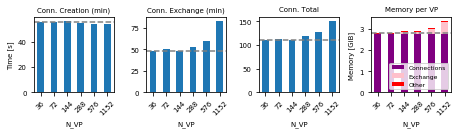

In [86]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
#print(hpc_t6_s20['N_conns_sum'])
#print(hpc_t6_s20['N_nrns'])

## HPC static

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,50.38,44.34,106.29,1.930745,0.082848,0.057636
72,50.39,47.27,108.31,1.930745,0.140628,0.055966
144,50.61,46.64,110.56,1.930745,0.138309,0.053382
288,48.95,49.19,110.87,1.951579,0.350760,0.053393
576,49.90,59.29,121.61,1.993245,0.419607,0.053747
1152,49.24,81.91,144.39,1.993083,0.452431,0.054612


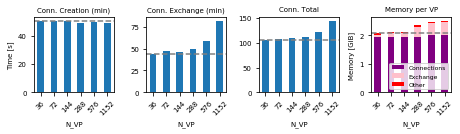

In [87]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_table.txt')
hpc_static_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,59.03,55.15,123.98,2.743245,0.022139,0.051125
72,59.38,62.68,130.93,2.743245,0.036027,0.053362
144,59.12,56.11,126.83,2.743245,0.113203,0.053382
288,57.37,59.52,130.55,2.743245,0.170184,0.053393
576,57.13,66.91,139.17,2.743245,0.520410,0.053747
1152,56.60,91.91,165.08,2.743083,0.604612,0.054612


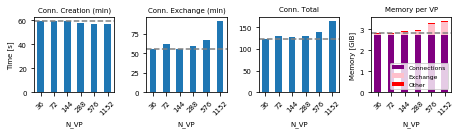

In [88]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_random_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_random_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_random_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,52.94,48.75,108.34,1.930745,0.395348,0.051125
72,53.27,48.90,109.68,1.930745,0.394128,0.053362
144,54.14,52.98,117.80,1.930745,0.403486,0.053382
288,52.39,53.71,117.39,1.951579,0.457815,0.053393
576,52.51,62.07,127.60,1.993245,0.417980,0.053747
1152,52.16,91.93,156.84,1.993083,0.452973,0.054612


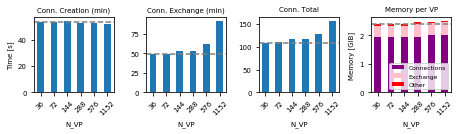

In [89]:
hpc_static_del_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static_random_delays.csv')

hpc_static_del_t6_s20 = calculate_T_conn_and_memory(hpc_static_del_t6_s20)
hpc_static_del_t6_s20_p = plot_results(hpc_static_del_t6_s20,
                                       'benchmark_figures/hpc_benchmark_static_random_delays.pdf')

save_table_latex(hpc_static_del_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_random_delays_table.txt')
hpc_static_del_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  55.93        59.03                   52.94          50.38   
72                  56.16        59.38                   53.27          50.39   
144                 56.73        59.12                   54.14          50.61   
288                 55.07        57.37                   52.39          48.95   
576                 53.97        57.13                   52.51          49.90   
1152                53.90        56.60                   52.16          49.24   

     Conn. Exchange (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  47.75        55.15                   48.75          44.34   
72                  50.03        62.68                   48.90          47.27   
144                 47.69        56.11                   52.98          46.64   
288                 52.39        59.52                   53.71          49.19   
576                 59.77        66.91                   62.07          59.29   
1152                83.27        91.91                   91.93          81.91   

     Conn. Total                                                      \
Case     Default Random delay Random delay and static Static synapse   
N_VP                                                                   
36        110.79       123.98                  108.34         106.29   
72        113.02       130.93                  109.68         108.31   
144       111.17       126.83                  117.80         110.56   
288       119.53       130.55                  117.39         110.87   
576       126.65       139.17                  127.60         121.61   
1152      150.91       165.08                  156.84         144.39   

     Memory per VP                                                      
Case       Default Random delay Random delay and static Static synapse  
N_VP                                                                    
36        2.822043     2.816509                2.377219       2.071229  
72        2.821839     2.832635                2.378235       2.127340  
144       2.905517     2.909830                2.387614       2.122436  
288       2.910500     2.966822                2.462787       2.355732  
576       3.035068     3.317403                2.464972       2.466600  
1152      3.382232     3.402306                2.500667       2.500125

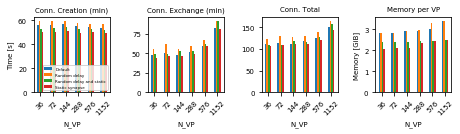

In [90]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_static_t6_s20['Case'] = ['Static synapse'] * len(hpc_static_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_static_del_t6_s20['Case'] = ['Random delay and static'] * len(hpc_static_del_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_static_t6_s20, hpc_delay_t6_s20, hpc_static_del_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf', legend_loc='lower right')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## Population model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,45.75,39.25,93.81,1.979818,0.105624,0.065204
72,46.64,40.00,95.79,1.975260,0.123853,0.071347
144,47.91,40.45,98.53,1.975260,0.215827,0.071367
288,50.44,43.82,103.67,1.975260,0.116873,0.071378
576,54.71,54.46,118.66,1.975260,0.398448,0.071732
1152,66.78,95.90,176.92,1.975260,0.454258,0.072434


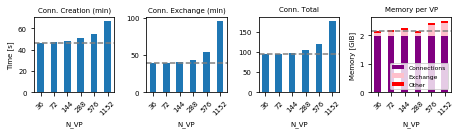

In [92]:
population = pd.read_csv('benchmark_results/population_model_8adec3cd_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

#print(population['N_conns_sum'])
#print(population['N_nrns'])
population_p

## HPC benchmark vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case        HPC Benchmark Population        HPC Benchmark Population   
N_VP                                                                   
36                  55.93      45.75                47.75      39.25   
72                  56.16      46.64                50.03      40.00   
144                 56.73      47.91                47.69      40.45   
288                 55.07      50.44                52.39      43.82   
576                 53.97      54.71                59.77      54.46   
1152                53.90      66.78                83.27      95.90   

       Conn. Total            Memory per VP             
Case HPC Benchmark Population HPC Benchmark Population  
N_VP                                                    
36          110.79      93.81      2.822043   2.150646  
72          113.02      95.79      2.821839   2.170461  
144         111.17      98.53      2.905517   2.262454  
288         119.53     103.67      2.910500   2.163512  
576         126.65     118.66      3.035068   2.445441  
1152        150.91     176.92      3.382232   2.501953

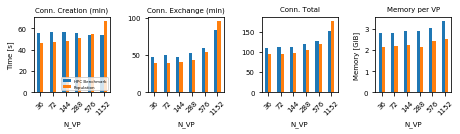

In [94]:
hpc_t6_s20['Case'] = ['HPC Benchmark'] * len(hpc_t6_s20)
population['Case'] = ['Population'] * len(population)

hpc_pop_cases = pd.concat([hpc_t6_s20, population], sort=True)

hpc_pop_cases_p = plot_compare(hpc_pop_cases, 'benchmark_figures/hpc_vs_pop.pdf')
save_table_latex(hpc_pop_cases_p.to_latex(), 'latex_tables/hpc_vs_pop_table.txt')

hpc_pop_cases_p

#### time per connection

Conn. Creation Time \n per Conn. (min)             \
Case                          HPC Benchmark Population   
N_VP                                                     
36                                 0.795378   0.658800   
72                                 0.798649   0.671616   
144                                0.806755   0.689904   
288                                0.783148   0.726336   
576                                0.767505   0.787824   
1152                               0.766510   0.961632   

     Conn. Exchange Time \n per Conn. (min)            Memory per connection  \
Case                          HPC Benchmark Population         HPC Benchmark   
N_VP                                                                           
36                                 0.679050   0.565200             42.236336   
72                                 0.711474   0.576000             42.273624   
144                                0.678197   0.582480             43.551069   
288                                0.745036   0.631008             43.626989   
576                                0.849987   0.784224             45.523682   
1152                               1.184179   1.380960             50.803273   

                Total Conn. Time per Conn.             
Case Population              HPC Benchmark Population  
N_VP                                                   
36    32.244856                   1.575539   1.350864  
72    32.456249                   1.607252   1.379376  
144   33.878331                   1.580944   1.418832  
288   32.348318                   1.699831   1.492848  
576   36.702005                   1.801084   1.708704  
1152  37.564931                   2.146085   2.547648

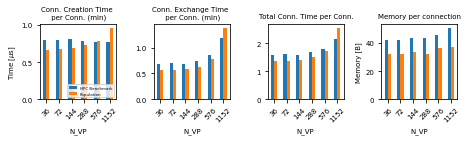

In [95]:
hpc_pop_tpc = time_and_memory_per_connection(hpc_pop_cases)
values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_pop_tpc['Conn. Creation Time \n per Conn. (min)'] = hpc_pop_tpc['Conn. Creation Time per Conn. (min)']
hpc_pop_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_pop_tpc['Conn. Exchange Time per Conn. (min)']

hpc_pop_tpc_p = plot_compare(hpc_pop_tpc, 'benchmark_figures/hpc_vs_pop_cases_time_per_conn.pdf',
                             values, legend_loc='lower right')
save_table_latex(hpc_pop_tpc_p.to_latex(),
                 'latex_tables/hpc_vs_pop_cases_time_per_conn_table.txt')

hpc_pop_tpc_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 5 * NUMBER_OF_NODES`

**Compare *all* rules:**

fixed indegree:
0      632869750
1     1265738500
2     2531476000
3     5062951000
4    10125901000
5    20251801000
Name: N_conns_sum, dtype: int64
0      56250
1     112500
2     225000
3     450000
4     900000
5    1800000
Name: N_nrns, dtype: int64
fixed_outdegree:
0      632869750
1     1265738500
2     2531476000
3     5062951000
4    10125901000
5    20251801000
Name: N_conns_sum, dtype: int64
0      56250
1     112500
2     225000
3     450000
4     900000
5    1800000
Name: N_nrns, dtype: int64
fixed_total_number:
0     632869750
1    1265738500
2    2531476000
3    5062951000
4    5830933704
5    7366899112
Name: N_conns_sum, dtype: int64
0      56250
1     112500
2     225000
3     450000
4     900000
5    1800000
Name: N_nrns, dtype: int64
fixed_total_number no sort:
0     632869750
1    1265738500
2    2531476000
3    5062951000
4    5830933704
5    7366899112
Name: N_conns_sum, dtype: int64
0      56250
1     112500
2     225000
3     450000
4     900000
5    1800000
Na

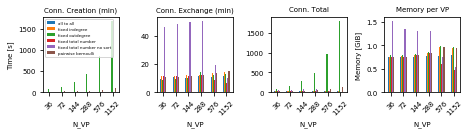

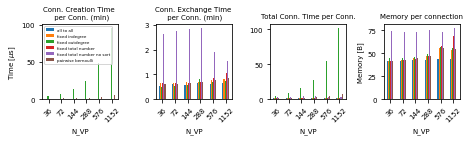

In [96]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_in.csv')
hpc_in['Case'] = ['fixed indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_out.csv')
hpc_out['Case'] = ['fixed outdegree']*len(hpc_out)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_all.csv')
hpc_all['Case'] = ['all to all']*len(hpc_all)

hpc_tot = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot.csv')
hpc_tot['Case'] = ['fixed total number']*len(hpc_tot)

hpc_tot_nosort = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot_nosort.csv')
hpc_tot_nosort['Case'] = ['fixed total number no sort']*len(hpc_tot_nosort)

#hpc_tot_gsl = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot_gsl.csv')
#hpc_tot_gsl['Case'] = ['fixed total number gsl']*len(hpc_tot_gsl)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_bern.csv')
hpc_bern['Case'] = ['pairwise bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_tot_nosort, hpc_out])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules_tpc = time_and_memory_per_connection(hpc_rules)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules['Conn. Creation Time \n per Conn. (min)'] = hpc_rules['Conn. Creation Time per Conn. (min)']
hpc_rules_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_tpc['Conn. Exchange Time per Conn. (min)']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')

hpc_rules_tpc_p = plot_compare(hpc_rules_tpc, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper left', logy=False)
save_table_latex(hpc_rules_tpc_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

print("fixed indegree:")
print(hpc_in['N_conns_sum'])
print(hpc_in['N_nrns'])

print("fixed_outdegree:")
print(hpc_out['N_conns_sum'])
print(hpc_out['N_nrns'])

print("fixed_total_number:")
print(hpc_tot['N_conns_sum'])
print(hpc_tot['N_nrns'])

print("fixed_total_number no sort:")
print(hpc_tot_nosort['N_conns_sum'])
print(hpc_tot_nosort['N_nrns'])

print("all to all:")
print(hpc_all['N_conns_sum'])
print(hpc_all['N_nrns'])

print("bernoulli:")
print(hpc_bern['N_conns_sum'])
print(hpc_bern['N_nrns'])

**Not including `fixed outdegree`:**

Conn. Creation (min)                                    \
Case           all to all fixed indegree fixed total number   
N_VP                                                          
36                  12.45          14.28              16.82   
72                  12.46          14.21              16.40   
144                 12.38          14.16              16.31   
288                 12.43          14.11              16.27   
576                 12.37          13.82               9.11   
1152                12.38          13.75               5.48   

                                                   Conn. Exchange (min)  \
Case fixed total number no sort pairwise bernoulli           all to all   
N_VP                                                                      
36                        16.71              16.30                 9.65   
72                        16.46              19.23                10.88   
144                       16.24              24.42                10.26   
288                       16.17              35.00                11.35   
576                        9.09              56.46                10.63   
1152                       5.48              99.22                11.31   

                                                                   \
Case fixed indegree fixed total number fixed total number no sort   
N_VP                                                                
36            11.16              11.18                      45.97   
72            11.35              11.41                      48.18   
144           11.90              11.79                      49.61   
288           12.47              12.54                      50.44   
576           13.59               8.56                      19.40   
1152          14.48               6.69                       9.86   

                        Conn. Total                                    \
Case pairwise bernoulli  all to all fixed indegree fixed total number   
N_VP                                                                    
36                10.63       23.94          27.73              30.34   
72                11.06       26.07          29.52              32.40   
144               11.41       25.64          29.99              32.76   
288               12.26       26.83          31.06              33.38   
576               13.58       25.84          32.14              20.24   
1152              15.12       27.24          33.00              13.56   

                                                   Memory per VP  \
Case fixed total number no sort pairwise bernoulli    all to all   
N_VP                                                               
36                        65.25              30.92      0.749755   
72                        67.62              34.27      0.756658   
144                       70.35              40.11      0.761072   
288                       71.09              51.29      0.763594   
576                       30.94              74.32      0.771211   
1152                      16.64             120.53      0.787419   

                                                                   \
Case fixed indegree fixed total number fixed total number no sort   
N_VP                                                                
36         0.754855           0.747314                   1.521992   
72         0.769299           0.762165                   1.347563   
144        0.786707           0.788687                   1.311857   
288        0.836700           0.836734                   1.296715   
576        0.967500           0.602672                   0.746254   
1152       0.945985           0.470433                   0.533292   

                         
Case pairwise bernoulli  
N_VP                     
36             0.754530  
72             0.758394  
144            0.787575  
288            0.835324  
576            0.970321  
1152           0.947477

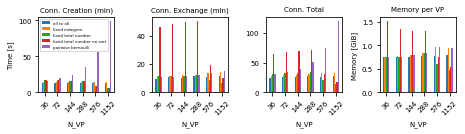

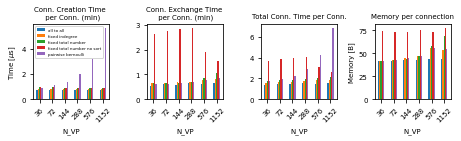

In [78]:
hpc_rules_no_out = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_tot_nosort])

hpc_rules_no_out = calculate_T_conn_and_memory(hpc_rules_no_out)
hpc_rules_no_out_tpc = time_and_memory_per_connection(hpc_rules_no_out)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules_no_out['Conn. Creation Time \n per Conn. (min)'] = hpc_rules_no_out['Conn. Creation Time per Conn. (min)']
hpc_rules_no_out_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_no_out_tpc['Conn. Exchange Time per Conn. (min)']

hpc_rules_no_out_p = plot_compare(hpc_rules_no_out, 'benchmark_figures/hpc_rules_no_out.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_no_out_p.to_latex(), 'latex_tables/hpc_rules_no_out_table.txt')
hpc_rules_no_out_tpc_p = plot_compare(hpc_rules_no_out_tpc, 'benchmark_figures/hpc_rules_no_out_time_per_connection.pdf',
                               values, legend_loc='upper left')
save_table_latex(hpc_rules_no_out_tpc_p.to_latex(), 'latex_tables/hpc_rules_no_out_time_per_connection_table.txt')

hpc_rules_no_out_p

In [79]:
hpc_tot

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,PLASTIC,RULE,NUM_VPS,num_tasks,T_nrns,T_conns_min,T_conns_max,T_conns_sum,T_ini_min,T_ini_max,T_equ,T_sim,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_spks_sum,Rate_sum,N_nrns,N_conns_sum,d_min,d_max,Case
0,1,6,6,5,True,tot,36,6,0.12,16.82,19.16,103.64,11.18,13.52,2.42,0.19,2128752,27534192,28056552,28210152,2790,5.2,56250,632869750,1.5,1.5,fixed total number
1,2,6,6,10,True,tot,72,12,0.13,16.40,20.99,207.11,11.41,16.00,2.22,0.26,4377232,55188112,56757120,57541504,7319,5.2,112500,1265738500,1.5,1.5,fixed total number
2,4,6,6,20,True,tot,144,24,0.11,16.31,21.02,415.39,11.79,16.45,2.49,0.26,9003208,110379208,118074024,119087784,14481,6.6,225000,2531476000,1.5,1.5,fixed total number
3,8,6,6,40,True,tot,288,48,0.26,16.27,20.84,823.58,12.54,17.11,2.61,0.32,17682192,220761872,252685272,252685272,32076,5.6,450000,5062951000,1.5,1.5,fixed total number
4,16,6,6,80,True,tot,576,96,0.22,9.11,11.69,919.55,8.56,11.13,0.67,0.07,36233448,240410856,364001912,364001912,4173,0.5,900000,5830933704,1.5,1.5,fixed total number
5,32,6,6,160,True,tot,1152,192,0.28,5.48,6.87,1104.19,6.69,8.14,0.85,0.08,73314584,301576472,568263736,568263736,6152,0.0,1800000,7366899112,1.5,1.5,fixed total number


In [80]:
hpc_in

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,PLASTIC,RULE,NUM_VPS,num_tasks,T_nrns,T_conns_min,T_conns_max,T_conns_sum,T_ini_min,T_ini_max,T_equ,T_sim,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_spks_sum,Rate_sum,N_nrns,N_conns_sum,d_min,d_max,Case
0,1,6,6,5,True,in,36,6,0.11,14.28,16.57,88.45,11.16,13.46,2.32,0.23,2128752,27534192,28034024,28494824,2913,5.3,56250,632869750,1.5,1.5,fixed indegree
1,2,6,6,10,True,in,72,12,0.11,14.21,18.20,178.16,11.35,15.31,2.31,0.26,4377232,55188112,56918912,58080128,7217,5.0,112500,1265738500,1.5,1.5,fixed indegree
2,4,6,6,20,True,in,144,24,0.23,14.16,18.09,357.72,11.90,15.83,2.37,0.26,9003208,110379208,118788776,118788776,13186,5.0,225000,2531476000,1.5,1.5,fixed indegree
3,8,6,6,40,True,in,288,48,0.22,14.11,18.59,716.70,12.47,16.95,4.44,0.56,17682192,220761872,252675032,252675032,33775,7.2,450000,5062951000,1.5,1.5,fixed indegree
4,16,6,6,80,True,in,576,96,0.33,13.82,18.55,1433.36,13.59,18.32,2.94,0.37,36233448,441737448,584350328,584350328,62366,6.8,900000,10125901000,1.5,1.5,fixed indegree
5,32,6,6,160,True,in,1152,192,0.30,13.75,18.52,2853.01,14.48,19.26,3.46,0.46,73314584,884322584,1142711352,1142711352,131788,6.1,1800000,20251801000,1.5,1.5,fixed indegree


**Not including `fixed total number`:**

Conn. Creation (min)                                                    \
Case           all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                          
36                  12.45          14.28           75.28              16.30   
72                  12.46          14.21          128.24              19.23   
144                 12.38          14.16          232.49              24.42   
288                 12.43          14.11          440.86              35.00   
576                 12.37          13.82          855.70              56.46   
1152                12.38          13.75         1685.13              99.22   

     Conn. Exchange (min)                                                    \
Case           all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                          
36                   9.65          11.16            9.01              10.63   
72                  10.88          11.35            9.46              11.06   
144                 10.26          11.90           10.08              11.41   
288                 11.35          12.47           14.00              12.26   
576                 10.63          13.59           12.01              13.58   
1152                11.31          14.48           12.69              15.12   

     Conn. Total                                                    \
Case  all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                 
36         23.94          27.73           88.63              30.92   
72         26.07          29.52          154.58              34.27   
144        25.64          29.99          278.94              40.11   
288        26.83          31.06          484.76              51.29   
576        25.84          32.14          963.10              74.32   
1152       27.24          33.00         1796.98             120.53   

     Memory per VP                                                    
Case    all to all fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                                  
36        0.749755       0.754855        0.799072           0.754530  
72        0.756658       0.769299        0.796995           0.758394  
144       0.761072       0.786707        0.817591           0.787575  
288       0.763594       0.836700        0.865889           0.835324  
576       0.771211       0.967500        0.994681           0.970321  
1152      0.787419       0.945985        0.966465           0.947477

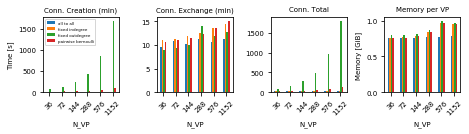

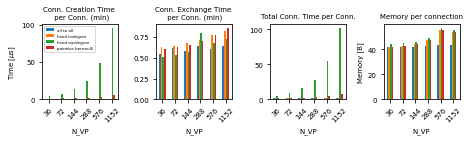

In [75]:
hpc_rules_no_tot = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out])

hpc_rules_no_tot = calculate_T_conn_and_memory(hpc_rules_no_tot)
hpc_rules_no_tot_tpc = time_and_memory_per_connection(hpc_rules_no_tot)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules_no_tot['Conn. Creation Time \n per Conn. (min)'] = hpc_rules_no_tot['Conn. Creation Time per Conn. (min)']
hpc_rules_no_tot_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_no_tot_tpc['Conn. Exchange Time per Conn. (min)']

hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_no_tot.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_table.txt')
hpc_rules_no_tot_tpc_p = plot_compare(hpc_rules_no_tot_tpc, 'benchmark_figures/hpc_rules_not_tot_time_per_connection.pdf',
                               values, legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_tpc_p.to_latex(), 'latex_tables/hpc_rules_no_tot_time_per_connection_table.txt')

hpc_rules_no_tot_p

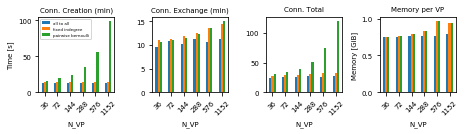

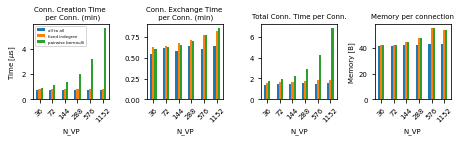

In [76]:
hpc_rules_no_fo = pd.concat([hpc_in, hpc_bern, hpc_all])

hpc_rules_no_fo = calculate_T_conn_and_memory(hpc_rules_no_fo)
hpc_rules_no_fo_tpc = time_and_memory_per_connection(hpc_rules_no_fo)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules_no_fo['Conn. Creation Time \n per Conn. (min)'] = hpc_rules_no_fo['Conn. Creation Time per Conn. (min)']
hpc_rules_no_fo_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_no_fo_tpc['Conn. Exchange Time per Conn. (min)']

hpc_rules_no_fo_p = plot_compare(hpc_rules_no_fo, 'benchmark_figures/hpc_rules_no_out.pdf',
                                 legend_loc='upper left')
save_table_latex(hpc_rules_no_fo_p.to_latex(), 'latex_tables/hpc_rules_no_out_table.txt')
hpc_rules_no_fo_tpc_p = plot_compare(hpc_rules_no_fo_tpc, 'benchmark_figures/hpc_rules_not_out_time_per_connection.pdf',
                                 values, legend_loc='upper left')
save_table_latex(hpc_rules_no_fo_tpc_p.to_latex(), 'latex_tables/hpc_rules_no_out_time_per_connection_table.txt')


## Multi-Area Model

KeyError: 'connections'

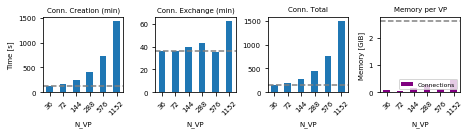

In [97]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_8adec3cd_daint_t6.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=False)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')

MAM_t6_s0_0625_p

print(MAM_t6_s0_0625['N_conns_sum'])
print(MAM_t6_s0_0625['N_nrns'])

## 4x4 mesocircuit

0      345443323
1      690927633
2     1381963143
3     2763938640
4     5527888387
5    11055874121
Name: N_conns_sum, dtype: int64
0      77169
1     154338
2     308676
3     617352
4    1234704
5    2469408
Name: N_nrns, dtype: int64


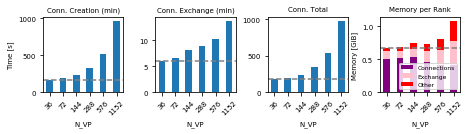

In [167]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_8adec4cd_daint_t6.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')

meso_t6_s0_0625_p

print(meso_t6_s0_0625['N_conns_sum'])
print(meso_t6_s0_0625['N_nrns'])

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time \n per Conn. (min)             \
Case                                    4x4        MAM   
N_VP                                                     
36                                17.825790   2.874098   
72                                20.316339   3.761778   
144                               23.753340   5.838750   
288                               34.791047   9.764916   
576                               54.317855  17.443326   
1152                             100.507309  34.302514   

                                          \
Case hpc random delay, static population   
N_VP                                       
36                   0.752857   0.658800   
72                   0.757550   0.671616   
144                  0.769923   0.689904   
288                  0.745036   0.726336   
576                  0.746742   0.787824   
1152                 0.741765   0.961632   

     Conn. Exchange Time \n per Conn. (min)            \
Case                                    4x4       MAM   
N_VP                                                    
36                                 0.629452  0.860384   
72                                 0.685687  0.873328   
144                                0.840891  0.946237   
288                                0.933624  1.039734   
576                                1.072207  0.852447   
1152                               1.428555  1.493779   

                                         Memory per connection            \
Case hpc random delay, static population                   4x4       MAM   
N_VP                                                                       
36                   0.693271   0.565200              0.067637  0.065630   
72                   0.695405   0.576000              0.068116  0.065420   
144                  0.753426   0.582480              0.072355  0.068241   
288                  0.763808   0.631008              0.068858  0.072114   
576                  0.882695   0.784224              0.069737  0.069639   
1152                 1.307333   1.380960              0.084737  0.084798   

                                         Total Conn. Time per Conn.  \
Case hpc random delay, static population                        4x4   
N_VP                                                                  
36                   0.034686   0.031489                  18.455242   
72                   0.034668   0.031696                  21.003068   
144                  0.034807   0.033084                  24.595272   
288                  0.035928   0.031590                  35.726755   
576                  0.035956   0.035842                  55.396314   
1152                 0.036475   0.036685                 101.949410   

                                                     
Case        MAM hpc random delay, static population  
N_VP                                                 
36     3.734491                 1.540698   1.350864  
72     4.635115                 1.559754   1.379376  
144    6.785010                 1.675229   1.418832  
288   10.804663                 1.669398   1.492848  
576   18.295799                 1.814594   1.708704  
1152  35.796336                 2.230415   2.547648

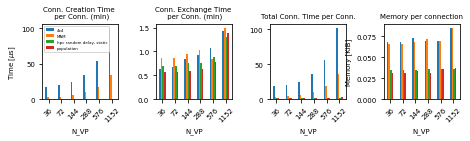

In [165]:
#hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
hpc_static_del_t6_s20[['Case']] = ['hpc random delay, static']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_static_del_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_and_memory_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_pop_MAM_4x4['Conn. Creation Time \n per Conn. (min)'] = hpc_pop_MAM_4x4['Conn. Creation Time per Conn. (min)']
hpc_pop_MAM_4x4['Conn. Exchange Time \n per Conn. (min)'] = hpc_pop_MAM_4x4['Conn. Exchange Time per Conn. (min)']


hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper left')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,17.40,11.70,29.40,1.915039,0.795025,0.386829
3,31.06,24.88,59.71,1.930013,0.293794,0.089876
6,41.26,34.54,81.53,1.995850,0.075687,0.047707
9,43.63,45.66,89.95,1.974826,0.076844,0.038896
18,57.58,71.10,130.47,1.953695,0.014393,0.040708
36,73.43,77.09,150.52,1.943454,0.020833,0.035204


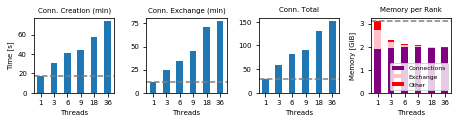

In [109]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                         Conn. Exchange (min)  \
Case                    2.14    2.16   2.18 8adec3cd                 2.14   
Threads                                                                     
1                      36.44   21.73  17.62    17.40                 0.62   
3                      47.89   38.73  30.85    31.06                 0.89   
6                      52.17   51.38  42.25    41.26                 0.96   
9                      53.47   58.84  43.85    43.63                 0.91   
18                     54.55   81.97  56.37    57.58                 1.38   
36                     61.78  124.92  74.22    73.43                 1.44   

                               Conn. Total                           \
Case      2.16   2.18 8adec3cd        2.14    2.16    2.18 8adec3cd   
Threads                                                               
1        18.79  11.87    11.70       38.13   41.59   29.74    29.40   
3        29.74  24.27    24.88       53.94   74.21   61.06    59.71   
6        35.99  32.64    34.54       55.97   89.20   78.62    81.53   
9        50.30  48.41    45.66       56.75  110.85   93.32    89.95   
18       66.25  68.98    71.10       58.47  151.96  127.35   130.47   
36       91.19  77.44    77.09       63.22  216.11  151.66   150.52   

        Memory per Rank                                
Case               2.14      2.16      2.18  8adec3cd  
Threads                                                
1              2.312773  5.072531  3.096897  3.096893  
3              2.028328  4.422857  2.269574  2.313683  
6              1.983972  4.332034  2.121685  2.119244  
9              1.973401  4.311907  2.100494  2.090566  
18             1.963256  4.293865  2.008091  2.008796  
36             1.968212  4.284930  1.989075  1.999492

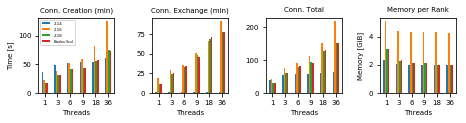

In [140]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_threads_218['Case'] = ['2.18']*len(hpc_threads_218)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')
hpc_threads_m['Case']   = ['8adec3cd']*len(hpc_threads_m)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_218, hpc_threads_m])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0, legend_loc='upper left')
save_table_latex(hpc_threads_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p

Conn. Total                        Memory per Rank                      \
Case        2.14   2.16   2.18 8adec3cd            2.14      2.16      2.18   
N_VP                                                                          
36         37.39  41.12  29.69    29.57        2.312611  5.072531  3.096897   
72         39.99  42.98  29.81    29.34        2.327074  5.073708  3.107514   
144        42.03  45.60  30.39    30.19        2.707514  5.075892  3.109698   
288        44.44  46.59  31.11    31.17        3.149024  5.080248  3.114054   
576        46.74  48.86  33.61    34.08        3.144015  5.108859  3.578192   
1152       49.62  55.41  39.56    40.25        3.161597  5.123802  4.092529   

               Simulation                           
Case  8adec3cd       2.14    2.16    2.18 8adec3cd  
N_VP                                                
36    3.096893      82.85   88.38   90.13    89.62  
72    3.107514      84.19   87.63   90.85    90.32  
144   3.109698      87.78   92.08   95.31    94.96  
288   3.114054      97.88  105.33  105.49   106.58  
576   3.577714     110.44  119.03  128.16   128.64  
1152  4.092366     140.54  163.31  172.90   173.25

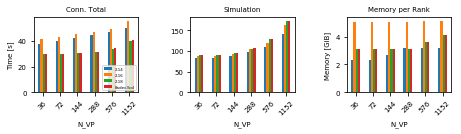

In [138]:
hpc_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_n1_s15.csv')
hpc_m['Case']   = ['8adec3cd']*len(hpc_m)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['num. nodes'] = hpc_versions['NUMBER_OF_NODES']
hpc_versions['Simulation'] = hpc_versions['T_sim']
hpc_versions_p = plot_compare(hpc_versions, 'benchmark_figures/hpc_different_versions.pdf',
                              values = ['Conn. Total', 'Simulation', 'Memory per Rank'],
                              rot=45)
save_table_latex(hpc_versions_p.to_latex(), 'latex_tables/hpc_different_versions.txt')

hpc_versions_p